In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from time import time

%matplotlib inline

In [2]:
file = pd.ExcelFile('dataPoints.xlsx')
df = file.parse('Foglio1')
df.head()

X = df[['x1', 'x2']].to_numpy()
y_true = df[['y']].to_numpy().reshape(1,-1)

X_train, X_test, y_train, y_test = train_test_split(X, y_true.reshape(-1,1), test_size=0.15, 
                                                    random_state=1869097)

y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)

In [3]:
def g_fun(T, sigma):
    num = np.exp(2*sigma*T) - 1
    den = np.exp(2*sigma*T) + 1
    return num / den

def convex_fun(X, v, W, b):
    
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X, -1* np.ones((X.shape[0], 1)), axis=1)
    Wb = np.append(W, b, axis=1)

    return np.dot(v.T, g_fun(np.dot(Wb, np.transpose(X1)), sigma))

def convex_Grad(v, X_train, y_true, W, b):
    
    # merge W with b
    Wb = np.append(W, b, axis=1)
    
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X_train, -1* np.ones((X_train.shape[0],1)), axis=1)

    # pick parameters from o
    v = v.reshape(N,1)
    omega = v.reshape(1,N)
        
    ### compute partial derivatives in a "pythonic" way:
    
    # for the sake of clearness, let's define some variables
    # (MATRIX1) dot product between Wb and X1
    T = np.dot(Wb, np.transpose(X1)) # NxX_train.shape[0] matrix
    
    # derivative of g()
    #g_der = 4 * sigma * np.exp(2 * sigma * T) / (np.exp(2 * sigma * T) + 1)**2

    dE_dv = 1 / X_train.shape[0] * np.dot(g_fun(T, sigma), \
                                          np.transpose(convex_fun(X_train, v, W, b) - y_true)) + 2 * rho * v

    return dE_dv.reshape(-1)

def convex_loss(v, X, y_true, W, b):
    y_pred = convex_fun(X, v, W, b)
    l = np.sum((y_pred - y_true)**2)/(2 * X.shape[0]) + rho * np.linalg.norm(v)**2
    #loss_history.append(l)
    return l


def non_convex_loss(omega, X, y_true, v):
    y_pred = non_convex_fun(X, omega, v)
    l = np.sum((y_pred - y_true)**2)/(2 * X.shape[0]) + rho * np.linalg.norm(omega)**2
    #loss_history.append(l)
    return l


def non_convex_fun(X, omega, v):  
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X, -1* np.ones((X.shape[0], 1)), axis=1)

    # extract param vectors from omega
    W = omega[0:n*N].reshape(N, n)
    b = omega[n*N:].reshape(N, 1)
    
    # merge W with b
    Wb = np.append(W, b, axis=1)
    return np.dot(v.T, g_fun(np.dot(Wb, np.transpose(X1)), sigma))

def non_convex_Grad(omega, X_train, y_true, v):
    
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X_train, -1* np.ones((X_train.shape[0],1)), axis=1)

    # pick parameters from omega one
    v = v.reshape(N,1)
    W = omega[0:n*N].reshape(N, n)
    b = omega[n*N:].reshape(N, 1)
    
    
    Wb = np.append(W,b, axis=1)
    
    ### compute partial derivatives in a "pythonic" way:
    
    # for the sake of clearness, let's define some variables
    # (MATRIX1) dot product between Wb and X1
    T = np.dot(Wb, np.transpose(X1)) # NxX_train.shape[0] matrix
    
    # derivative of g()
    g_der = 4 * sigma * np.exp(2 * sigma * T) / (np.exp(2 * sigma * T) + 1)**2

    #dE_dv = 1 / X_train.shape[0] * np.dot(g_fun(T, sigma), np.transpose(fun(X_train, omega) - y_true)) + 2 * rho * v
    dE_db = 1 / X_train.shape[0] * np.dot(-1 * v * g_der, \
                                          np.transpose(non_convex_fun(X_train, omega, v) - y_true)) + 2 * rho * b
    
    # dealing with dE_dW
    mat1 = v * g_der * X1[:,0]
    mat1 = np.dot(mat1, np.transpose(non_convex_fun(X_train, omega, v) - y_true))
    mat2 = v * g_der * X1[:,1]
    mat2 = np.dot(mat2, np.transpose(non_convex_fun(X_train, omega, v) - y_true))

    fusion = np.append(mat1, mat2, axis=1)
    dE_dW = 1 / X_train.shape[0] * fusion + 2 * rho * W

    omega_gradient = np.concatenate((dE_dW.reshape(N*n,1), dE_db))
    return omega_gradient.reshape(-1)

def MLP_fun(X, omega):
    
    # creating matrix X1 (X matrix plus array of ones)
    X1 = np.append(X, -1* np.ones((X.shape[0], 1)), axis=1)

    # extract param vectors from omega
    v = omega[0:N].reshape(N, 1)
    W = omega[N:3*N].reshape(N, n)
    b = omega[3*N:].reshape(N,1)
    
    # merge W with b
    Wb = np.append(W, b, axis=1)
    
    return np.dot(v.T, g_fun(np.dot(Wb, np.transpose(X1)), sigma))

def MLP_loss(omega, X, y_true):
    y_pred = MLP_fun(X, omega)
    l = np.sum((y_pred - y_true)**2)/(2 * X.shape[0]) + rho * np.linalg.norm(omega)**2
    #loss_history.append(l)
    return l

In [4]:
file = pd.ExcelFile('dataPoints.xlsx')
df = file.parse('Foglio1')
df.head()

X = df[['x1', 'x2']].to_numpy()
y_true = df[['y']].to_numpy().reshape(1,-1)

X_train, X_test, y_train, y_test = train_test_split(X, y_true.reshape(-1,1), test_size=0.15, 
                                                    random_state=1869097)

y_train = y_train.reshape(1,-1)
y_test = y_test.reshape(1,-1)

In [5]:
N = 30
n = np.shape(X)[1]
sigma = 1.8
rho = 0.00001


loss_history = []

W = np.random.randn(N,n)
b = np.random.randn(N,1)
v = np.random.randn(N,1)

# merge W with b
#Wb = np.append(W, b, axis=1)

t1 = time()
res = minimize(convex_loss, v, jac = convex_Grad, args=(X_train, y_train, W, b), method = "BFGS",
               options = {'gtol': 1e-8})
t1 = time()-t1
print(t1)

0.23363685607910156


In [6]:
print(res.message)
print('exec time:', t1)
print('fun:', res.fun)
print('success:',res.success)
print('nfev:', res.nfev)
print('nit:', res.nit)
print('njev:', res.njev)

Optimization terminated successfully.
exec time: 0.23363685607910156
fun: 0.05301207999255857
success: True
nfev: 260
nit: 258
njev: 260


In [7]:
np.linalg.norm(convex_Grad(res.x, X_train, y_train, W, b))

9.651187660415945e-09

In [8]:
# save the result 
v_star = res.x.copy().reshape(-1,1)

In [9]:
#create_omega
omega = np.concatenate((W.reshape(N*n, 1), b)).reshape(-1)
print(omega.shape)

(90,)


In [10]:
#print(non_convex_Grad(omega, X_train, y_train, v_star).shape)
#print(W.shape[0]*W.shape[1] + b.shape[0]) # check if it's the same.. OK! 

In [11]:
#non_convex_loss(omega, X, y_true, v_star)

In [12]:
t1 = time()
# adding a threshold on the gradient norm between 1e-2 and 1e-5
res = minimize(non_convex_loss, omega, jac = non_convex_Grad, args=(X_train, y_train, v_star), method = "BFGS",
               options={'gtol':1e-3})
t1 = time() - t1

In [13]:
print(res.message)
print('exec time:', t1)
print('fun:', res.fun)
print('success:',res.success)
print('nfev:', res.nfev)
print('nit:', res.nit)
print('njev:', res.njev)

Optimization terminated successfully.
exec time: 0.4460940361022949
fun: 0.0015402065503565706
success: True
nfev: 258
nit: 252
njev: 258


In [14]:
# losses
v_star
W_and_b_star = res.x

W_star = res.x[0:n*N].reshape(N, n)
b_star = res.x[n*N:].reshape(N,1)


print('---- Convex loss ----')
print('train:', convex_loss(v_star, X_train, y_train, W_star, b_star))
print('test:', convex_loss(v_star, X_test, y_test, W_star, b_star), '\n')


print('---- Non Convex loss ----')
print('train:', non_convex_loss(W_and_b_star, X_train, y_train, v_star))
print('test:', non_convex_loss(W_and_b_star, X_test, y_test, v_star), '\n')



omega_star = np.concatenate((v_star.reshape(-1,1), W_star.reshape(N*n,1), b_star)).reshape(-1)

print('---- Overall loss ----')
print('train:', MLP_loss(omega_star, X_train, y_train))
print('test:', MLP_loss(omega_star, X_test, y_test))

---- Convex loss ----
train: 0.0014458754880373114
test: 0.0015392604750524123 

---- Non Convex loss ----
train: 0.0015402065503565706
test: 0.0016335915373716715 

---- Overall loss ----
train: 0.0027557457064837643
test: 0.0028491306934988647


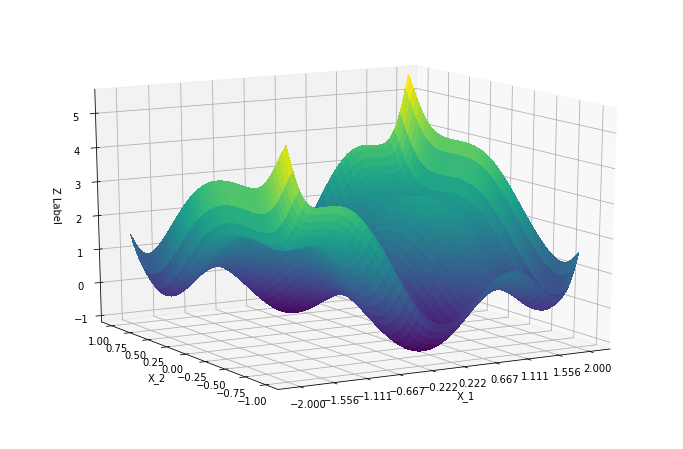

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

X_1 = np.linspace(-2,2,100)
X_2 = np.linspace(-1,1,100)
X_1, X_2 = np.meshgrid(X_1, X_2)
zs = np.array([MLP_fun(np.array([x,y]).reshape(1,2), omega_star) for x,y in zip(np.ravel(X_1), np.ravel(X_2))])
Z = zs.reshape(X_1.shape)
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
ax.plot_surface(X_1, X_2, Z ,linewidth=0,cmap=cm.viridis, antialiased=False)
ax.set_xticks((np.linspace(-2,2,10)))
ax.view_init(elev=15, azim=240)
ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_zlabel('Z Label')
plt.savefig('graph_question_1_1.png',dpi=600)
plt.show()

# Hyperloop

In [16]:
def stopping_creteria(X_train, y_train, v, W, b, threshold=[1e-8, 1e-3]):
    
    eps1 = threshold[0]
    eps2 = threshold[1]
    
    conv_gradient = convex_Grad(v, X_train, y_train, W, b)
    
    W_and_b = np.concatenate((W.reshape(N*n,1), b)).reshape(-1)
    non_conv_gradient = non_convex_Grad(W_and_b, X_train, y_train, v)
    

    conv_module = np.linalg.norm(conv_gradient)
    non_conv_module = np.linalg.norm(non_conv_gradient)
    
    #print(conv_module, non_conv_module)
    
    if (conv_module < eps1) and (non_conv_module < eps2):
        return True
    else:
        return False

In [17]:
#stopping_creteria(X_train, y_train, res.x, W, b)

In [18]:
#while(stopping_creteria(X_train, y_train, v, W, b)):
    # minimize the convex func
    # update v
    
    # minimize the non convex func
    # update W and b
#    pass

In [22]:
N = 30
n = np.shape(X)[1]
sigma = 1.8
rho = 0.00001
max_iter = 100


history = {}

W = np.random.randn(N,n)
b = np.random.randn(N,1)
v = np.random.randn(N,1)

cnt = 0

print('starting 2 block-decomposition routine, max number of iterations: {}' .format(max_iter))
while not stopping_creteria(X_train, y_train, v, W, b) and cnt <= max_iter:
    
    print('{}, ' .format(cnt), end='')
    
    res = minimize(convex_loss, v, jac = convex_Grad, args=(X_train, y_train, W, b), method = "BFGS",
               options = {'gtol': 1e-8})
    
    #if res.success is False:
    #    print('1:NOOOOOOOOOOOOOO', res.success)
    #else:
    #    print('1:', res.success)
    
    v_star = res.x.copy()
    
    omega = res.x.copy() # for the final evaluation of MLP_loss
    
    W_and_b = np.concatenate((W.reshape(N*n,1), b))
    
    res = minimize(non_convex_loss, W_and_b, jac=non_convex_Grad, args=(X_train, y_train, v_star), 
                   method = "BFGS", options={'gtol':1e-5})

    #if res.success is False:
    #    print('2:NOOOOOOOOOOOOOO', res.success)
    #else:
    #    print('2:', res.success)
    
    W_star = res.x[0:n*N].reshape(N,n)
    b_star = res.x[n*N:].reshape(N,1)
    
    v = v_star.copy()
    W = W_star.copy()
    b = b_star.copy()
    cnt = cnt + 1
    

print('...done')

starting 2 block-decomposition routine, max number of iterations: 100
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, ...done


In [23]:
omega_star = np.concatenate((v.reshape(-1,1), W.reshape(N*n,1), b)).reshape(-1)
print(MLP_loss(omega_star, X_train, y_train))
print(MLP_loss(omega_star, X_test, y_test))

0.0022662954663643653
0.002253720959617332


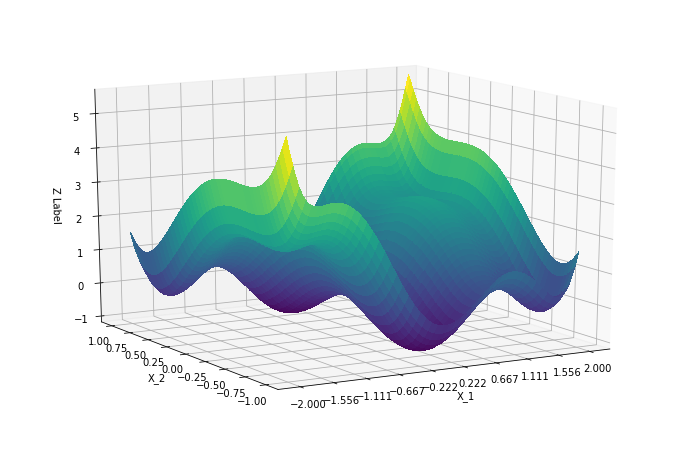

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

X_1 = np.linspace(-2,2,100)
X_2 = np.linspace(-1,1,100)
X_1, X_2 = np.meshgrid(X_1, X_2)
zs = np.array([MLP_fun(np.array([x,y]).reshape(1,2), omega_star) for x,y in zip(np.ravel(X_1), np.ravel(X_2))])
Z = zs.reshape(X_1.shape)
fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
ax.plot_surface(X_1, X_2, Z ,linewidth=0,cmap=cm.viridis, antialiased=False)
ax.set_xticks((np.linspace(-2,2,10)))
ax.view_init(elev=15, azim=240)
ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_zlabel('Z Label')
plt.savefig('graph_question_1_1.png',dpi=600)
plt.show()